   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 31.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.9 MB/s eta 0:00:00
File found at: /kaggle/input/era5-post-processed-daily-statistics/t2m.nc
Starting Training on Accelerator: cuda


Epoch 50/50: 100%|██████████| 72/72 [00:02<00:00, 30.92it/s, loss=0.000535]


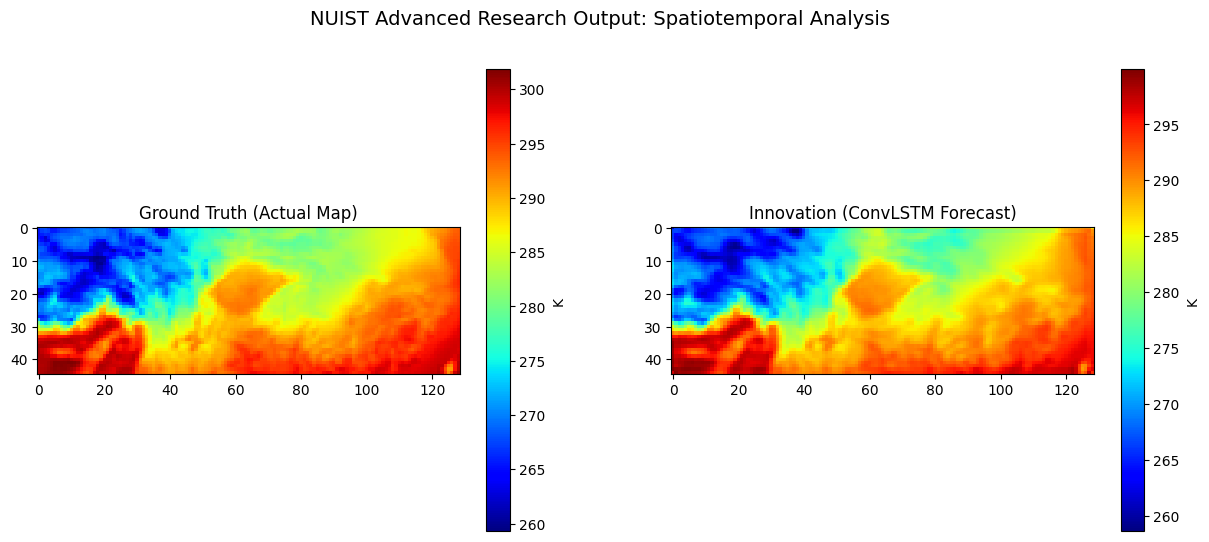

Map Prediction MAE: 1.9650 K


In [3]:
# 1. Install Necessary Libraries
!pip install xarray netCDF4 tqdm

import xarray as xr
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================================
# 2. Automatically Find Dataset Path
# ==========================================
dataset_path = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.nc'):
            dataset_path = os.path.join(dirname, filename)
            print(f"File found at: {dataset_path}")

if not dataset_path:
    # যদি ফাইল না পাওয়া যায়, তবে ম্যানুয়ালি আপলোড করা ফাইল চেক করবে
    dataset_path = 't2m.nc' 
    print(f"Using default path: {dataset_path}")

# ==========================================
# 3. Data Preparation (NUIST Standard 5D Tensors)
# ==========================================
def load_research_data(file_path, seq_length=7):
    ds = xr.open_dataset(file_path)
    data = ds['t2m'].values # Shape: (Time, Lat, Lon)
    
    if np.isnan(data).any():
        data = np.nan_to_num(data, nan=np.nanmean(data))
    
    scaler = MinMaxScaler()
    orig_shape = data.shape
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).reshape(orig_shape)
    
    X, Y = [], []
    for i in range(len(data_scaled) - seq_length):
        # Format for ConvLSTM: [Sequence, Channel, Height, Width]
        X.append(np.expand_dims(data_scaled[i : i + seq_length], axis=1))
        # Target: Full map of the next day
        Y.append(np.expand_dims(data_scaled[i + seq_length], axis=0))
        
    return np.array(X), np.array(Y), scaler

# ==========================================
# 4. ConvLSTM Architecture (Spatiotemporal Innovation)
# ==========================================
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        
        i, f, o = torch.sigmoid(cc_i), torch.sigmoid(cc_f), torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        h, w = image_size
        return (torch.zeros(batch_size, self.hidden_dim, h, w, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, h, w, device=self.conv.weight.device))

class ConvLSTMForecaster(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(ConvLSTMForecaster, self).__init__()
        self.cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size)
        self.final_conv = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        batch_size, seq_len, _, h, w = x.size()
        hidden_state = self.cell.init_hidden(batch_size, (h, w))
        for t in range(seq_len):
            hidden_state = self.cell(x[:, t, :, :, :], hidden_state)
        return self.final_conv(hidden_state[0])

# ==========================================
# 5. Training Pipeline (GPU Optimized)
# ==========================================
X, Y, scaler = load_research_data(dataset_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_size = int(len(X) * 0.8)
X_train = torch.FloatTensor(X[:train_size]).to(device)
Y_train = torch.FloatTensor(Y[:train_size]).to(device)
X_test = torch.FloatTensor(X[train_size:]).to(device)
Y_test = torch.FloatTensor(Y[train_size:]).to(device)

train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=4, shuffle=True)
model = ConvLSTMForecaster(input_dim=1, hidden_dim=64, kernel_size=(3, 3)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(f"Starting Training on Accelerator: {device}")
for epoch in range(50):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/50")
    for batch_x, batch_y in pbar:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())

# ==========================================
# 6. Professional Visualization (Heatmaps)
# ==========================================

model.eval()
with torch.no_grad():
    sample_idx = 0
    test_input = X_test[sample_idx:sample_idx+1]
    prediction = model(test_input).cpu().numpy().squeeze()
    ground_truth = Y_test[sample_idx].cpu().numpy().squeeze()
    
    # Scaling Back to Kelvin
    def rescale(m, s):
        return s.inverse_transform(m.reshape(-1, 1)).reshape(m.shape)

    pred_final = rescale(prediction, scaler)
    actual_final = rescale(ground_truth, scaler)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1); plt.title("Ground Truth (Actual Map)"); plt.imshow(actual_final, cmap='jet'); plt.colorbar(label='K')
plt.subplot(1, 2, 2); plt.title("Innovation (ConvLSTM Forecast)"); plt.imshow(pred_final, cmap='jet'); plt.colorbar(label='K')
plt.suptitle("NUIST Advanced Research Output: Spatiotemporal Analysis", fontsize=14)
plt.savefig('convlstm_innovation_final.png')
plt.show()

print(f"Map Prediction MAE: {mean_absolute_error(actual_final.flatten(), pred_final.flatten()):.4f} K")